In [4]:
!pip install -q kaggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import locale

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')


'en_US.UTF-8'

In [5]:
df = pd.read_csv("Tweets.csv")
df = df[['text', 'airline_sentiment']]
df.head()


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


/tmp/ipython-input-6-3982044290.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, palette='Set2')


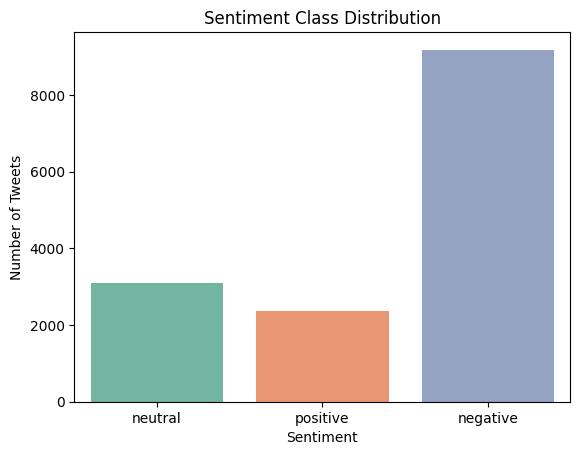

In [6]:
sns.countplot(x='airline_sentiment', data=df, palette='Set2')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()


In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df['clean_text'] = df['text'].apply(clean_text)


encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['airline_sentiment'])


In [8]:
X = df['clean_text']
y = df['label']

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=100)

X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2, random_state=42)


In [10]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.build(input_shape=(None, 100))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,219 (1.35 MB)

 Trainable params: 353,219 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64)


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - accuracy: 0.6494 - loss: 0.8559 - val_accuracy: 0.7732 - val_loss: 0.5917
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.7929 - loss: 0.5311 - val_accuracy: 0.8081 - val_loss: 0.4943
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 118ms/step - accuracy: 0.8488 - loss: 0.3978 - val_accuracy: 0.8053 - val_loss: 0.4997
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.8835 - loss: 0.3128 - val_accuracy: 0.8012 - val_loss: 0.5052
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.9000 - loss: 0.2760 - val_accuracy: 0.7985 - val_loss: 0.5464


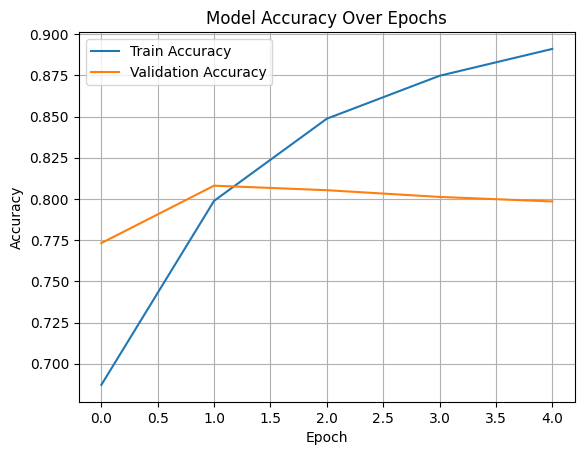

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7963 - loss: 0.5597
Test Accuracy: 0.7985
Test Loss: 0.5464


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      1889
     neutral       0.62      0.56      0.59       580
    positive       0.79      0.65      0.71       459

    accuracy                           0.80      2928
   macro avg       0.75      0.71      0.73      2928
weighted avg       0.79      0.80      0.79      2928



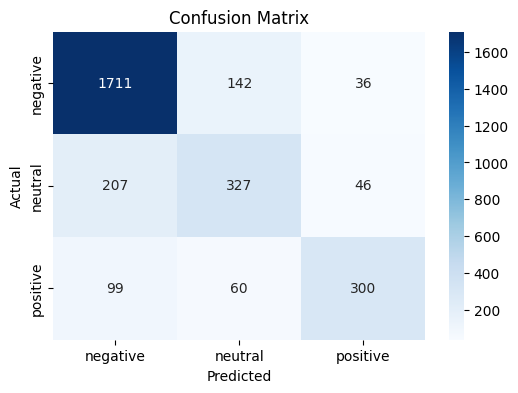

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


y_pred_probs = model.predict(X_test)


y_pred = np.argmax(y_pred_probs, axis=1)


print(classification_report(y_test, y_pred, target_names=encoder.classes_))


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [17]:
sample_texts = [
    "I had a great flight experience with United Airlines!",
    "My flight was delayed for 5 hours. Very disappointed.",
    "Nothing special, just a regular trip."
]


sample_cleaned = [clean_text(t) for t in sample_texts]
sample_seq = tokenizer.texts_to_sequences(sample_cleaned)
sample_pad = pad_sequences(sample_seq, maxlen=100)


sample_pred = model.predict(sample_pad)
predicted_labels = encoder.inverse_transform(np.argmax(sample_pred, axis=1))

for text, label in zip(sample_texts, predicted_labels):
    print(f"{text} → Sentiment: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
I had a great flight experience with United Airlines! → Sentiment: positive
My flight was delayed for 5 hours. Very disappointed. → Sentiment: negative
Nothing special, just a regular trip. → Sentiment: neutral


## 📊 Conclusion

This project successfully demonstrates sentiment classification using LSTM on Twitter data related to U.S. airlines.

- The model achieved **~80% accuracy** on the test set.
- Predictions on custom tweets showed logical sentiment detection.
- LSTM was trained on 10K+ real-world tweets, and performed well without pre-trained embeddings.

### 📌 Possible Improvements
- Use of pre-trained embeddings like GloVe or Word2Vec
- Bi-directional LSTM for better context understanding
- Hyperparameter tuning (LSTM units, dropout, batch size)
